[Table of Contents](./table_of_contents.ipynb)

# Particle Filters

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Motivation

Here is our problem. We have moving objects that we want to track. Maybe the objects are fighter jets and missiles, or maybe we are tracking people playing cricket in a field. It doesn't really matter. Which of the filters that we have learned can handle this problem? Unfortunately, none of them are ideal. Let's think about the characteristics of this problem. 

* **multimodal**: We want to track zero, one, or more than one object simultaneously.

* **occlusions**: One object can hide another, resulting in one measurement for multiple objects.

* **nonlinear behavior**: Aircraft are buffeted by winds, balls move in parabolas, and people collide into each other.

* **nonlinear measurements**: Radar gives us the distance to an object. Converting that to an (x,y,z) coordinate requires a square root, which is nonlinear.

* **non-Gaussian noise:** as objects move across a background the computer vision can mistake part of the background for the object. 

* **continuous:** the object's position and velocity (i.e. the state space) can smoothly vary over time.

* **multivariate**: we want to track several attributes, such as position, velocity, turn rates, etc.

* **unknown process model**: we may not know the process model of the system

None of the filters we have learned work well with all of these constraints. 

* **Discrete Bayes filter**: This has most of the attributes. It is multimodal, can handle nonlinear measurements, and can be extended to work with nonlinear behavior. However, it is discrete and univariate.

* **Kalman filter**: The Kalman filter produces optimal estimates for unimodal linear systems with Gaussian noise. None of these are true for our problem.

* **Unscented Kalman filter**: The UKF handles nonlinear, continuous, multivariate problems. However, it is not multimodal nor does it handle occlusions. It can handle noise that is modestly non-Gaussian, but does not do well with distributions that are very non-Gaussian or problems that are very nonlinear.

* **Extended Kalman filter**: The EKF has the same strengths and limitations as the UKF, except that is it even more sensitive to strong nonlinearities and non-Gaussian noise.

## Monte Carlo Sampling

In the UKF chapter I generated a plot similar to this to illustrate the effects of nonlinear systems on Gaussians:

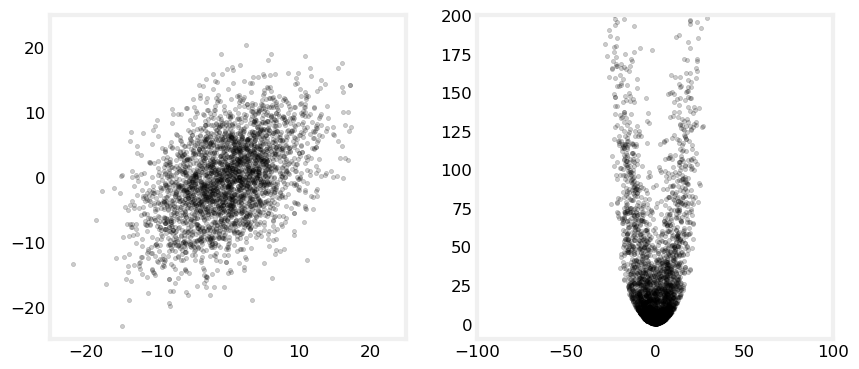

In [3]:
import kf_book.pf_internal as pf_internal
pf_internal.plot_monte_carlo_ukf()

The left plot shows 3,000 points normally distributed based on the Gaussian

$$ \mu = \begin{bmatrix}0\\0\end{bmatrix},\, \, \, \Sigma = \begin{bmatrix}32&15\\15&40\end{bmatrix} $$

The right plots shows these points passed through this set of equations:

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$ 

Using a finite number of randomly sampled points to compute a result is called a [*Monte Carlo*](https://en.wikipedia.org/wiki/Monte_Carlo_method) (MC) method. The idea is simple. Generate enough points to get a representative sample of the problem, run the points through the system you are modeling, and then compute the results on the transformed points. 

In a nutshell this is what particle filtering does. The Bayesian filter algorithm we have been using throughout the book is applied to thousands of particles, where each particle represents a *possible* state for the system. We extract the estimated state from the thousands of particles using weighted statistics of the particles.

## Generic Particle Filter Algorithm

1. **Randomly generate a bunch of particles**
    
  Particles can have position, heading, and/or whatever other state variable you need to estimate. Each has a weight (probability) indicating how likely it matches the actual state of the system. Initialize each with the same weight.
  
2. **Predict next state of the particles**

 Move the particles based on how you predict the real system is behaving.

3. **Update**

  Update the weighting of the particles based on the measurement. Particles that closely match the measurements are weighted higher than particles which don't match the measurements very well.
  
4. **Resample**

  Discard highly improbable particle and replace them with copies of the more probable particles.
  
5. **Compute Estimate**

  Optionally, compute weighted mean and covariance of the set of particles to get a state estimate.

This naive algorithm has practical difficulties which we will need to overcome, but this is the general idea. Let's see an example. I wrote a particle filter for the robot localization problem from the UKF and EKF chapters. The robot has steering and velocity control inputs. It has sensors that measures distance to visible landmarks. Both the sensors and control mechanism have noise in them, and we need to track the robot's position.

Here I run a particle filter and plotted the positions of the particles. The plot on the left is after one iteration, and on the right is after 10. The red 'X' shows the actual position of the robot, and the large circle is the computed weighted mean position.

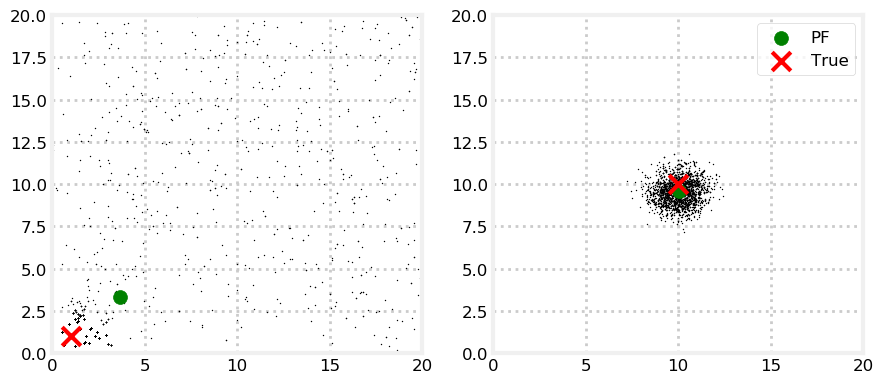

In [4]:
pf_internal.show_two_pf_plots()

If you are viewing this in a browser, this animation shows the entire sequence:

<img src='animations/particle_filter_anim.gif'>

After the first iteration the particles are still largely randomly scattered around the map, but you can see that some have already collected near the robot's position. The computed mean is quite close to the robot's position. This is because each particle is weighted based on how closely it matches the measurement. The robot is near (1,1), so particles that are near (1, 1) will have a high weight because they closely match the measurements. Particles that are far from the robot will not match the measurements, and thus have a very low weight. The estimated position is computed as the weighted mean of positions of the particles. Particles near the robot contribute more to the computation so the estimate is quite accurate.

Several iterations later you can see that all the particles have clustered around the robot. This is due to the *resampling* step. Resampling discards particles that are very improbable (very low weight) and replaces them with particles with higher probability. 

I haven't fully shown *why* this works nor fully explained the algorithms for particle weighting and resampling, but it should make intuitive sense. Make a bunch of random particles,  move them so they 'kind of' follow the robot, weight them according to how well they match the measurements, only let the likely ones live. It seems like it should work, and it does. 

## Probability distributions via Monte Carlo

Suppose we want to know the area under the curve $y= \mathrm{e}^{\sin(x)}$ in the interval [0, $\pi$]. The area is computed with the definite integral $\int_0^\pi  \mathrm{e}^{\sin(x)}\, \mathrm{d}x$. As an exercise, go ahead and find the answer; I'll wait. 

If you are wise you did not take that challenge; $\mathrm{e}^{\sin(x)}$ cannot be integrated analytically. The world is filled with equations which we cannot integrate. For example, consider calculating the luminosity of an object. An object reflects some of the light that strike it. Some of the reflected light bounces off of other objects and restrikes the original object, increasing the luminosity. This creates a *recursive integral*. Good luck with that one.

However, integrals are trivial to compute using a Monte Carlo technique. To find the area under a curve create a bounding box that contains the curve in the desired interval. Generate randomly positioned point within the box, and compute the ratio of points that fall under the curve vs the total number of points. For example, if 40% of the points are under the curve and the area of the bounding box is 1, then the area under the curve is approximately 0.4.  As you tend towards infinite points you can achieve any arbitrary precision. In practice, a few thousand points will give you a fairly accurate result.

You can use this technique to numerically integrate a function of any arbitrary difficulty. this includes non-integrable and noncontinuous functions. This technique was invented by Stanley Ulam at Los Alamos National Laboratory to allow him to perform computations for nuclear reactions which were unsolvable on paper.

Let's compute $\pi$ by finding the area of a circle. We will define a circle with a radius of 1, and bound it in a square. The side of the square has length 2, so the area is 4. We generate a set of uniformly distributed random points within the box, and count how many fall inside the circle. The area of the circle is computed as the area of the box times the ratio of points inside the circle vs. the total number of points. Finally, we know that $A = \pi r^2$, so we compute $\pi = A / r^2$.

We start by creating the points.

```python
N = 20000
pts = uniform(-1, 1, (N, 2))
```

A point is inside a circle if its distance from the center of the circle is less than or equal to the radius. We compute the distance with `numpy.linalg.norm`, which computes the magnitude of a vector. Since vectors start at (0, 0) calling norm will compute the point's distance from the origin.

```python
dist = np.linalg.norm(pts, axis=1)
```

Next we compute which of this distances fit the criteria. This code returns a bool array that contains `True` if it meets the condition `dist <= 1`:

```python
in_circle = dist <= 1
```

All that is left is to count the points inside the circle, compute pi, and plot the results. I've put it all in one cell so you can experiment with alternative values for `N`, the number of points.

mean pi(N=20000)= 3.1684
err  pi(N=20000)= -0.0268


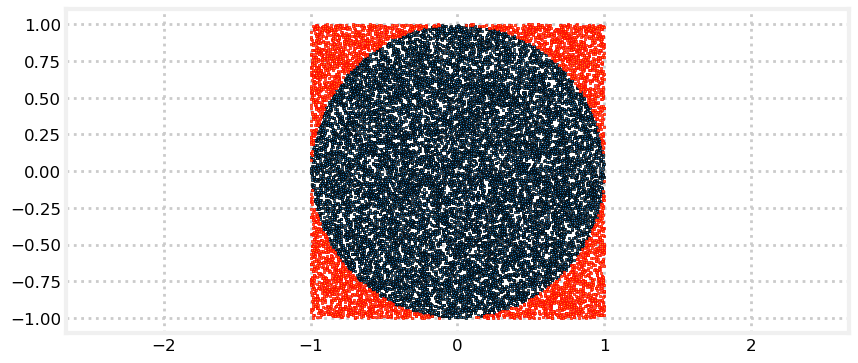

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform 

N = 20000  # number of points
radius = 1.
area = (2*radius)**2

pts = uniform(-1, 1, (N, 2))

# distance from (0,0) 
dist = np.linalg.norm(pts, axis=1)
in_circle = dist <= 1

pts_in_circle = np.count_nonzero(in_circle)
pi = 4 * (pts_in_circle / N)

# plot results
plt.scatter(pts[in_circle,0], pts[in_circle,1], 
            marker=',', edgecolor='k', s=1)
plt.scatter(pts[~in_circle,0], pts[~in_circle,1], 
            marker=',', edgecolor='r', s=1)
plt.axis('equal')

print(f'mean pi(N={N})= {pi:.4f}')
print(f'err  pi(N={N})= {np.pi-pi:.4f}')

This insight leads us to the realization that we can use Monte Carlo to compute the probability density of any probability distribution. For example, suppose we have this Gaussian:

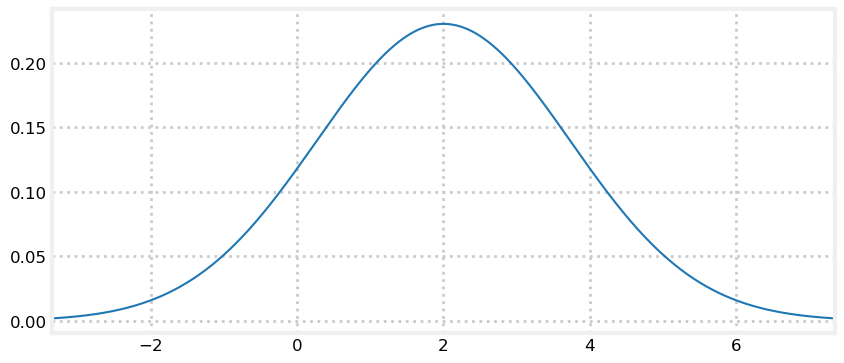

In [6]:
from filterpy.stats import plot_gaussian_pdf
plot_gaussian_pdf(mean=2, variance=3);

The probability density function (PDF) gives the probability that the random value falls between 2 values. For example, we may want to know the probability of x being between 0 and 2 in the graph above. This is a continuous function, so we need to take the integral to find the area under the curve, as the area is equal to the probability for that range of values to occur. 
 
$$P[a \le X \le b] = \int_a^b f_X(x) \, dx$$

It is easy to compute this integral for a Gaussian. But real life is not so easy. For example, the plot below shows a probability distribution. There is no way to analytically describe an arbitrary curve, let alone integrate it.

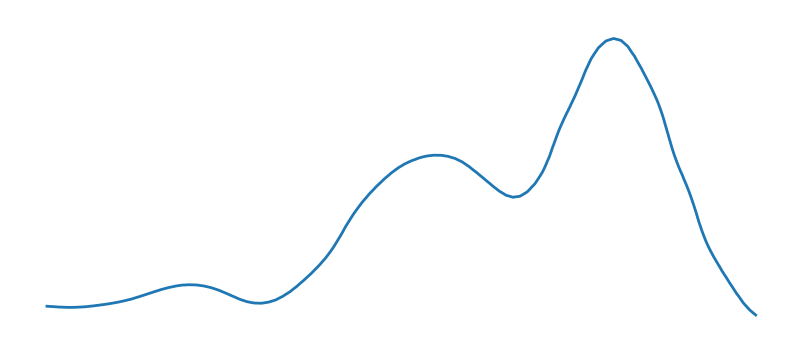

In [7]:
pf_internal.plot_random_pd()

We can use Monte Carlo methods to compute any integral. The PDF is computed with an integral, hence we can compute the PDF of this curve using Monte Carlo. 

## The Particle Filter

All of this brings us to the particle filter. Consider tracking a robot or a car in an urban environment. For consistency I will use the robot localization problem from the EKF and UKF chapters. In this problem we tracked a robot that has a sensor which measures the range and bearing to known landmarks. 

Particle filters are a family of algorithms. I'm presenting a specific form of a particle filter that is intuitive to grasp and relates to the problems we have studied in this book. This will leave a few of the steps seeming a bit 'magical' since I haven't offered a full explanation. That will follow later in the chapter.

Taking insight from the discussion in the previous section we start by creating several thousand *particles*. Each particle has a position that represents a possible belief of where the robot is in the scene, and perhaps a heading and velocity. Suppose that we have no knowledge of the location of the robot. We would want to scatter the particles uniformly over the entire scene. If you think of all of the particles representing a probability distribution, locations where there are more particles represent a higher belief, and locations with fewer particles represents a lower belief. If there was a large clump of particles near a specific location that would imply that we were more certain that the robot is there.

Each particle needs a weight - ideally the probability that it represents the true position of the robot. This probability is rarely computable, so we only require it be *proportional*  to that probability, which is computable. At initialization we have no reason to favor one particle over another, so we assign a weight of $1/N$, for $N$ particles. We use $1/N$ so that the sum of all probabilities equals one.

The combination of particles and weights forms the *probability distribution* for our problem. Think back to the *Discrete Bayes* chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. This is very similar except the particles are randomly distributed in a continuous space rather than constrained to discrete locations. In this problem the robot can move on a plane of some arbitrary dimension, with the lower right corner at (0,0).

To track our robot we need to maintain states for x, y, and heading. We will store `N` particles in a `(N, 3)` shaped array. The three columns contain x, y, and heading, in that order. 

If you are passively tracking something (no control input), then you would need to include velocity in the state and use that estimate to make the prediction. More dimensions requires exponentially more particles to form a good estimate, so we always try to minimize the number of random variables in the state.

This code creates a uniform and Gaussian distribution of particles over a region:

In [8]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

For example:

In [9]:
create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.772, 0.336, 4.171],
       [0.333, 0.34 , 4.319],
       [0.6  , 0.274, 5.02 ],
       [0.054, 0.022, 5.034]])

### Predict Step

The predict step in the Bayes algorithm uses the process model to update the belief in the system state. How would we do that with particles? Each particle represents a possible position for the robot. Suppose we send a command to the robot to move 0.1 meters while turning by 0.007 radians. We could move each particle by this amount. If we did that we would soon run into a problem. The robot's controls are not perfect so it will not move exactly as commanded. Therefore we need to add noise to the particle's movements to have a reasonable chance of capturing the actual movement of the robot. If you do not model the uncertainty in the system the particle filter will not correctly model the probability distribution of our belief in the robot's position.

In [10]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

### Update Step

Next we get a set of measurements - one for each landmark currently in view. How should these measurements be used to alter our probability distribution as modeled by the particles?

Think back to the **Discrete Bayes** chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. We assigned a probability to each position which we called the *prior*. When a new measurement came in we multiplied the current probability of that position (the *prior*) by the *likelihood* that the measurement matched that location:

```python
def update(likelihood, prior):
    posterior = prior * likelihood
    return normalize(posterior)
```

which is an implementation of the equation

$$x = \| \mathcal L \bar x \|$$

which is a realization of Bayes theorem:

$$\begin{aligned}P(x \mid z) &= \frac{P(z \mid x)\, P(x)}{P(z)} \\
 &= \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization}}\end{aligned}$$

In [15]:
import scipy
scipy.stats.norm(1,2).pdf(2)

0.17603266338214976

We do the same with our particles. Each particle has a position and a weight which estimates how well it matches the measurement. Normalizing the weights so they sum to one turns them into a probability distribution. The particles those that are closest to the robot will generally have a higher weight than ones far from the robot.

In [13]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In the literature this part of the algorithm is called *Sequential Importance Sampling*, or SIS. The equation for the weights is called the *importance density*. I will give these theoretical underpinnings in a following section. For now I hope that this makes intuitive sense. If we weight the particles according to how well they match the measurements they are probably a good sample for the probability distribution of the system after incorporating the measurements. Theory proves this is so. The weights are the *likelihood* in Bayes theorem. Different problems will need to tackle this step in slightly different ways but this is the general idea.

### Computing the State Estimate

In most applications you will want to know the estimated state after each update, but the filter consists of nothing but a collection of particles. Assuming that we are tracking one object (i.e. it is unimodal) we can compute the mean of the estimate as the sum of the weighted values of the particles. 

$$\displaystyle \mu = \frac{1}{N}\sum_{i=1}^N w^ix^i$$

Here I adopt the notation $x^i$ to indicate the $\mathtt{i}^{th}$ particle. A superscript is used because we often need to use subscripts to denote time steps the $\mathtt{k}^{th}$ or $\mathtt{k+1}^{th}$ particle, yielding the unwieldy $x^i_{k+1}$. 

This function computes both the mean and variance of the particles:

In [16]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

If we create a uniform distribution of points in a 1x1 square with equal weights we get a mean position very near the center of the square at (0.5, 0.5) and a small variance.

In [17]:
particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

(array([0.494, 0.514]), array([0.083, 0.085]))

### Particle Resampling

The SIS algorithm suffers from the *degeneracy problem*. It starts with uniformly distributed particles with equal weights. There may only be a handful of particles near the robot. As the algorithm runs any particle that does not match the measurements will acquire an extremely low weight. Only the particles which are near the robot will have an appreciable weight. We could have 5,000 particles with only 3 contributing meaningfully to the state estimate! We say the filter has *degenerated*.This problem is usually solved by some form of *resampling* of the particles. 

Particles with very small weights do not meaningfully describe the probability distribution of the robot. The resampling algorithm discards particles with very low probability and replaces them with new particles with higher probability. It does that by duplicating particles with relatively high probability. The duplicates are slightly dispersed by the noise added in the predict step. This results in a set of points in which a large majority of the particles accurately represent the probability distribution.

There are many resampling algorithms.  For now let's look at one of the simplest, *simple random resampling*, also called *multinomial resampling*. It samples from the current particle set $N$ times, making a new set of particles from the sample. The probability of selecting any given particle should be proportional to its weight.

We accomplish this with NumPy's `cumsum` function. `cumsum` computes the cumulative sum of an array. That is, element one is the sum of elements zero and one, element two is the sum of elements zero, one and two, etc. Then we generate random numbers in the range of 0.0 to 1.0 and do a binary search to find the weight that most closely matches that number:

In [14]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

We don't resample at every epoch. For example, if you received no new measurements you have not received any information from which the resample can benefit. We can determine when to resample by using something called the *effective N*, which approximately measures the number of particles which meaningfully contribute to the probability distribution. The equation for this is

$$\hat{N}_\text{eff} = \frac{1}{\sum w^2}$$

and we can implement this in Python with

In [19]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

If $\hat{N}_\text{eff}$ falls below some threshold it is time to resample. A useful starting point is $N/2$, but this varies by problem. It is also possible for $\hat{N}_\text{eff} = N$, which means the particle set has collapsed to one point (each has equal weight). It may not be theoretically pure, but if that happens I create a new distribution of particles in the hopes of generating particles with more diversity. If this happens to you often, you may need to increase the number of particles, or otherwise adjust your filter. We will talk more of this later.

## SIR Filter  - A Complete Example

There is more to learn, but we know enough to implement a full particle filter. We will implement the *Sampling Importance Resampling filter*, or SIR.

I need to introduce a more sophisticated resampling method than I gave above. FilterPy provides several resampling methods. I will describe them later. They take an array of weights and returns indexes to the particles that have been chosen for the resampling. We just need to write a function that performs the resampling from these indexes:

In [20]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

To implement the filter we need to create the particles and the landmarks. We then execute a loop, successively calling `predict`, `update`, resampling, and then computing the new state estimate with `estimate`.

final position error, variance:
	 [-0.106  0.106] [0.009 0.008]


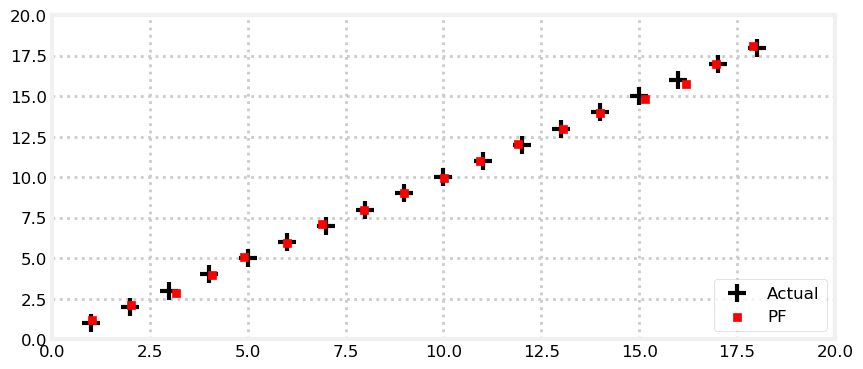

In [24]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)

Most of this code is devoted to initialization and plotting. The entirety of the particle filter processing consists of these lines:

```python
# move diagonally forward to (x+1, x+1)
predict(particles, u=(0.00, 1.414), std=(.2, .05))

 # incorporate measurements
update(particles, weights, z=zs, R=sensor_std_err, 
       landmarks=landmarks)
       
# resample if too few effective particles
if neff(weights) < N/2:
    indexes = systematic_resample(weights)
    resample_from_index(particles, weights, indexes)

mu, var = estimate(particles, weights)
```

The first line predicts the position of the particles with the assumption that the robot is moving in a straight line (`u[0] == 0`) and moving 1 unit in both the x and y axis (`u[1]==1.414`). The standard deviation for the error in the turn is 0.2, and the standard deviation for the distance is 0.05. When this call returns the particles will all have been moved forward, but the weights are no longer correct as they have not been updated.

The next line incorporates the measurement into the filter. This does not alter the particle positions, it only alters the weights. If you recall the weight of the particle is computed as the probability that it matches the Gaussian of the sensor error model. The further the particle from the measured distance the less likely it is to be a good representation.

The final two lines example the effective particle count ($\hat{N}_\text{eff})$. If it falls below $N/2$ we perform resampling to try to ensure our particles form a good representation of the actual probability distribution.

Now let's look at this with all the particles plotted. Seeing this happen interactively is much more instructive, but this format still gives us useful information. I plotted the original random distribution of points in a very pale green and large circles to help distinguish them from the subsequent iterations where the particles are plotted with black pixels. The number of particles makes it hard to see the details, so I limited the number of iterations to 8 so we can zoom in and look more closely.

final position error, variance:
	 [-0.019 -0.005] [0.005 0.006]


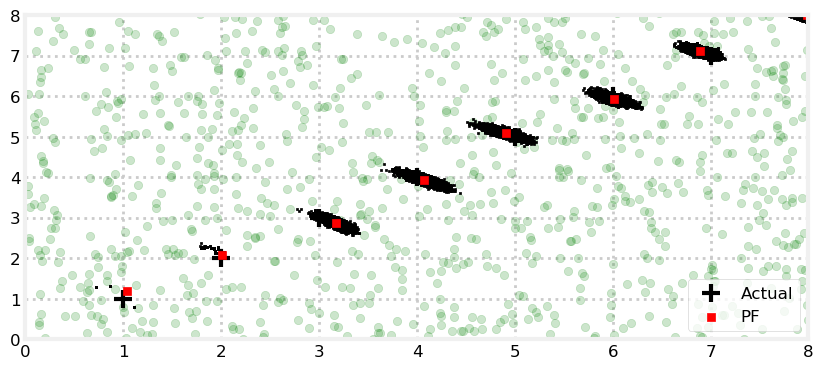

In [25]:
seed(2)
run_pf1(N=5000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

From the plot it looks like there are only a few particles at the first two robot positions. This is not true; there are 5,000 particles, but due to resampling most are duplicates of each other. The reason for this is the Gaussian for the sensor is very narrow. This is called *sample impoverishment* and can lead to filter divergence. I'll address this in detail below. For now, looking at the second step at x=2 we can see that the particles have dispersed a bit. This dispersion is due to the motion model noise. All particles are projected forward according to the control input `u`, but noise is added to each particle proportional to the error in the control mechanism in the robot. By the third step the particles have dispersed enough to make a convincing cloud of particles around the robot. 

The shape of the particle cloud is an ellipse. This is not a coincidence. The sensors and robot control are both modeled as Gaussian, so the probability distribution of the system is also a Gaussian. The particle filter is a sampling of the probability distribution, so the cloud should be an ellipse.

It is important to recognize that the particle filter algorithm *does not require* the sensors or system to be Gaussian or linear. Because we represent the probability distribution with a cloud of particles we can handle any probability distribution and strongly nonlinear problems. There can be discontinuities and hard limits in the probability model. 

### Effect of Sensor Errors on the Filter

The first few iterations of the filter resulted in many duplicate particles. This happens because the model for the sensors is Gaussian, and we gave it a small standard deviation of $\sigma=0.1$. This is  counterintuitive at first. The Kalman filter performs better when the noise is smaller, yet the particle filter can perform worse.


We can reason about why this is true. If $\sigma=0.1$, the robot is at (1, 1) and a particle is at (2, 2) the particle is 14 standard deviations away from the robot. This gives it a near zero probability. It contributes nothing to the estimate of the mean, and it is extremely unlikely to survive after the resampling. If $\sigma=1.4$ then the particle is only $1\sigma$ away and thus it will contribute to the estimate of the mean. During resampling it is likely to be copied one or more times.

This is *very important* to understand - a very accurate sensor can lead to poor performance of the filter because few of the particles will be a good sample of the probability distribution. There are a few fixes available to us. First, we can artificially increase the sensor noise standard deviation so the particle filter will accept more points as matching the robots probability distribution. This is non-optimal because some of those points will be a poor match. The real problem is that there aren't enough points being generated such that enough are near the robot. Increasing `N` usually fixes this problem. This decision is not cost free as increasing the number of particles significantly increase the computation time. Still, let's look at the result of using 100,000 particles.

final position error, variance:
	 [-0.17   0.084] [0.005 0.005]


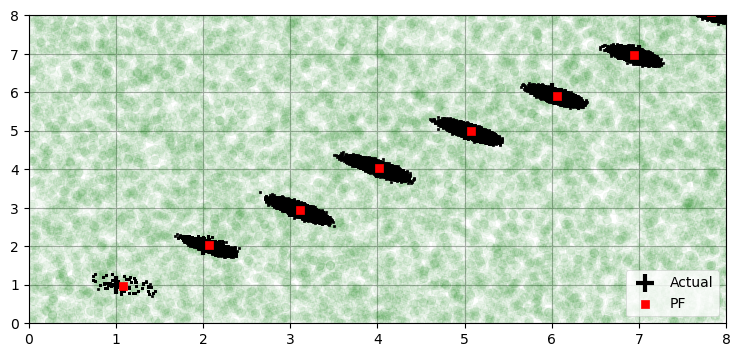

In [19]:
seed(2) 
run_pf1(N=100000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

There are many more particles at x=1, and we have a convincing cloud at x=2. Clearly the filter is performing better, but at the cost of large memory usage and long run times.

Another approach is to be smarter about generating the initial particle cloud. Suppose we guess that the robot is near (0, 0). This is not exact, as the simulation actually places the robot at (1, 1), but it is close. If we create a normally distributed cloud near (0, 0) there is a much greater chance of the particles matching the robot's position.

`run_pf1()` has an optional parameter `initial_x`. Use this to specify the initial position guess for the robot. The code then uses `create_gaussian_particles(mean, std, N)` to create particles distributed normally around the initial guess. We will use this in the next section.

### Filter Degeneracy From Inadequate Samples

The filter as written is far from perfect. Here is how it performs with a different random seed.

final position error, variance:
	 [ -2.688 -31.47 ] [47.065 47.03 ]


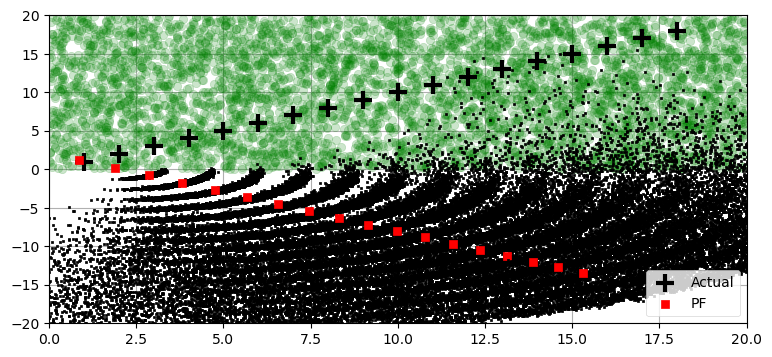

In [20]:
seed(6) 
run_pf1(N=5000, plot_particles=True, ylim=(-20, 20))

Here the initial sample of points did not generate any points near the robot. The particle filter does not create new points during the resample operation, so it ends up duplicating points which are not a representative sample of the probability distribution. As mentioned earlier this is called *sample impoverishment*. The problem quickly spirals out of control. The particles are not a good match for the landscape measurement so they become dispersed in a highly nonlinear, curved distribution, and the particle filter diverges from reality. No particles are available near the robot, so it cannot ever converge.

Let's make use of the `create_gaussian_particles()` method to try to generate more points near the robot. We can do this by using the `initial_x` parameter to specify a location to create the particles.

final position error, variance:
	 [ 0.035 -0.077] [0.007 0.009]


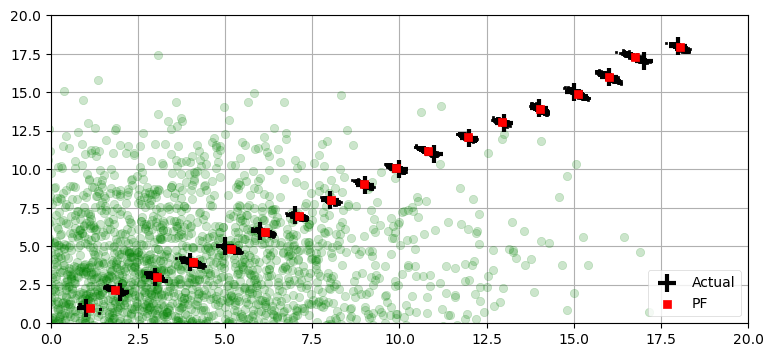

In [21]:
seed(6) 
run_pf1(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

This works great. You should always try to create particles near the initial position if you have any way to roughly estimate it. Do not be *too* careful - if you generate all the points very near a single position the particles may not be dispersed enough to capture the nonlinearities in the system. This is a fairly linear system, so we could get away with a smaller variance in the distribution. Clearly this depends on your problem. Increasing the number of particles is always a good way to get a better sample, but the processing cost may be a higher price than you are willing to pay.

## Importance Sampling

I've hand waved a difficulty away which we must now confront. There is some probability distribution that describes the position and movement of our robot. We want to draw a sample of particles from that distribution and compute the integral using MC methods. 

Our difficulty is that in many problems we don't know the distribution. For example, the tracked object might move very differently than we predicted with our state model. How can we draw a sample from a probability distribution that is unknown? 

There is a theorem from statistics called [*importance sampling*](https://en.wikipedia.org/wiki/Importance_sampling)[1]. Remarkably, it gives us a way to draw samples from a different and known probability distribution and use those to compute the properties of the unknown one. It's a fantastic theorem that brings joy to my heart. 

The idea is simple, and we already used it. We draw samples from the known probability distribution, but *weight the samples* according to the distribution we are interested in. We can then compute properties such as the mean and variance by computing the weighted mean and weighted variance of the samples.

For the robot localization problem we drew samples from the probability distribution that we computed from our state model prediction step. In other words, we reasoned 'the robot was there, it is perhaps moving at this direction and speed, hence it might be here'. Yet the robot might have done something completely different. It may have fell off a cliff or been hit by a mortar round. In each case the probability distribution is not correct. It seems like we are stymied, but we are not because we can use importance sampling. We drew particles from that likely incorrect probability distribution, then weighted them according to how well the particles match the measurements. That weighting is based on the true probability distribution, so according to the theory the resulting mean, variance, etc, will be correct!

How can that be true? I'll give you the math; you can safely skip this if you don't plan to go beyond the robot localization problem. However, other particle filter problems require different approaches to importance sampling, and a bit of math helps. Also, the literature and much of the content on the web uses the mathematical formulation in favor of my rather imprecise "imagine that..." exposition. If you want to understand the literature you will need to know the following equations.

We have some probability distribution $\pi(x)$ which we want to take samples from. However, we don't know what $\pi(x)$ is; instead we only know an alternative probability distribution $q(x)$. In the context of robot localization, $\pi(x)$ is the probability distribution for the robot, but we don't know it, and $q(x)$ is the probability distribution of our measurements, which we do know.

The expected value of a function $f(x)$ with probability distribution $\pi(x)$ is

$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\, dx$$

We don't know $\pi(x)$ so we cannot compute this integral. We do know an alternative distribution $q(x)$ so we can add it into the integral without changing the value with

$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\frac{q(x)}{q(x)}\, dx$$

Now we rearrange and group terms

$$\mathbb{E}\big[f(x)\big] = \int f(x)q(x)\, \,  \cdot \,  \frac{\pi(x)}{q(x)}\, dx$$

$q(x)$ is known to us, so we can compute $\int f(x)q(x)$ using MC integration. That leaves us with  $\pi(x)/q(x)$.  That is a ratio, and we define it as a *weight*. This gives us

$$\mathbb{E}\big[f(x)\big] = \sum\limits_{i=1}^N f(x^i)w(x^i)$$

Maybe that seems a little abstract. If we want to compute the mean of the particles we would compute

$$\mu = \frac{1}{N}\sum\limits_{i=1}^N x^iw^i$$

which is the equation I gave you earlier in the chapter.

It is required that the weights be proportional to the ratio $\pi(x)/q(x)$. We normally do not know the exact value, so in practice we normalize the weights by dividing them by $\sum w(x^i)$.

When you formulate a particle filter algorithm you will have to implement this step depending on the particulars of your situation. For robot localization the best distribution to use for $q(x)$ is the particle distribution from the `predict()` step of the filter. Let's look at the code again:

```python
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        dist = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(dist, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
```
   
Here we compute the weight as the based on the Bayesian computation $\| \text{likelihood} \times \text{prior}\|$

Of course if you can compute the posterior probability distribution from the prior you should do so. If you cannot, then importance sampling gives you a way to solve this problem. In practice, computing the posterior is incredibly difficult. The Kalman filter became a spectacular success because it took advantage of the properties of Gaussians to find an analytic solution. Once we relax the conditions required by the Kalman filter (Markov property, Gaussian measurements and process) importance sampling and monte carlo methods make the problem tractable.

## Resampling Methods

The resampling algorithm affects the performance of the filter. For example, suppose we resampled particles by picking particles at random. This would lead us to choosing many particles with a very low weight, and the resulting set of particles would be a terrible representation of the problem's probability distribution. 

Research on the topic continues, but a handful of algorithms work well in practice across a wide variety of situations. We desire an algorithm that has several properties. It should preferentially select particles that have a higher probability. It should select a representative population of the higher probability particles to avoid sample impoverishment. It should include enough lower probability particles to give the filter a chance of detecting strongly nonlinear behavior. 

FilterPy implements several of the popular algorithms. FilterPy doesn't know how your particle filter is implemented, so it cannot generate the new samples. Instead, the algorithms create a `numpy.array` containing the indexes of the particles that are chosen. Your code needs to perform the resampling step. For example, I used this for the robot:

In [26]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

### Multinomial Resampling

Multinomial resampling is the algorithm that I used while developing the robot localization example. The idea is simple. Compute the cumulative sum of the normalized weights. This gives you an array of increasing values from 0 to 1. Here is a plot which illustrates how this spaces out the weights. The colors are meaningless, they just make the divisions easier to see.

cumulative sume is [0.1 0.3 0.4 1. ]


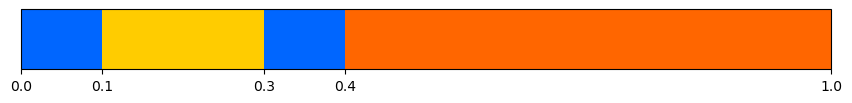

In [23]:
from kf_book.pf_internal import plot_cumsum
print('cumulative sume is', np.cumsum([.1, .2, .1, .6]))
plot_cumsum([.1, .2, .1, .6])

To select a weight we generate a random number uniformly selected between 0 and 1 and use binary search to find its position inside the cumulative sum array. Large weights occupy more space than low weights, so they are more likely to be selected. 

This is very easy to code using NumPy's [ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) support. Ufuncs apply functions to every element of an array, returning an array of the results. `searchsorted` is NumPy's binary search algorithm. If you provide it with an array of search values it will return an array of answers: a single answer for each search value. 

In [27]:
def multinomal_resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    return np.searchsorted(cumulative_sum, random(len(weights)))    

Here is an example:

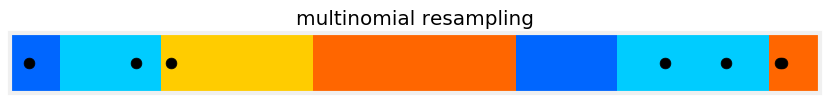

In [28]:
from kf_book.pf_internal import plot_multinomial_resample
plot_multinomial_resample([.1, .2, .3, .4, .2, .3, .1])

This is an $O(n \log(n))$ algorithm. That is not terrible, but there are $O(n)$ resampling algorithms with better properties with respect to the uniformity of the samples. I'm showing it because you can understand the other algorithms as variations on this one. There is a faster implementation of this multinomial resampling that uses the inverse of the CDF of the distribution. You can search on the internet if you are interested.

Import the function from FilterPy using

```python
from filterpy.monte_carlo import multinomal_resample
```

### Residual Resampling

Residual resampling both improves the run time of multinomial resampling, and ensures that the sampling is uniform across the population of particles. It's fairly ingenious: the normalized weights are multiplied by *N*, and then the integer value of each weight is used to define how many samples of that particle will be taken. For example, if the weight of a particle is 0.0012 and $N$=3000, the scaled weight is 3.6, so 3 samples will be taken of that particle. This ensures that all higher weight particles are chosen at least once. The running time is $O(N)$, making it faster than multinomial resampling.

However, this does not generate all *N* selections. To select the rest, we take the *residual*: the weights minus the integer part, which leaves the fractional part of the number. We then use a simpler sampling scheme such as multinomial, to select the rest of the particles based on the residual. In the example above the scaled weight was 3.6, so the residual will be 0.6 (3.6 - int(3.6)). This residual is very large so the particle will be likely to be sampled again. This is reasonable because the larger the residual the larger the error in the round off, and thus the particle was relatively under sampled in the integer step.

In [26]:
def residual_resample(weights):
    N = len(weights)
    indexes = np.zeros(N, 'i')

    # take int(N*w) copies of each weight
    num_copies = (N*np.asarray(weights)).astype(int)
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # use multinormial resample on the residual to fill up the rest.
    residual = w - num_copies     # get fractional part
    residual /= sum(residual)     # normalize
    cumulative_sum = np.cumsum(residual)
    cumulative_sum[-1] = 1. # ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

    return indexes

You may be tempted to replace the inner for loop with a slice `indexes[k:k + num_copies[i]] = i`, but very short slices are comparatively slow, and the for loop usually runs faster.

Let's look at an example:

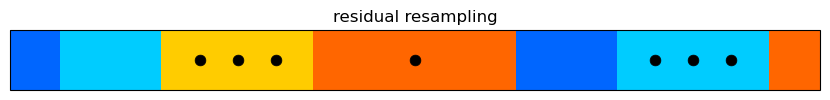

In [27]:
from kf_book.pf_internal import plot_residual_resample
plot_residual_resample([.1, .2, .3, .4, .2, .3, .1])

You may import this from FilterPy using

```python
    from filterpy.monte_carlo import residual_resample
```

### Stratified Resampling

This scheme aims to make selections relatively uniformly across the particles. It works by dividing the cumulative sum into $N$ equal sections, and then selects one particle randomly from each section.  This guarantees that each sample is between 0 and $\frac{2}{N}$ apart.

The plot below illustrates this. The colored bars show the cumulative sum of the array, and the black lines show the $N$ equal subdivisions. Particles, shown as black circles, are randomly placed in each subdivision.

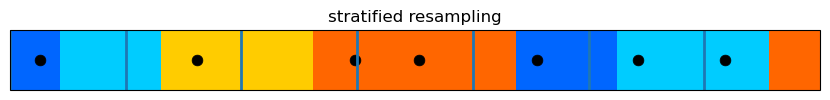

In [28]:
from kf_book.pf_internal import plot_stratified_resample
plot_stratified_resample([.1, .2, .3, .4, .2, .3, .1])

The code to perform the stratification is quite straightforward. 

In [29]:
def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

Import it from FilterPy with

```python
from filterpy.monte_carlo import stratified_resample
```

### Systematic Resampling

The last algorithm we will look at is systemic resampling. As with stratified resampling the space is divided into $N$ divisions. We then choose a random offset to use for all of the divisions, ensuring that each sample is exactly $\frac{1}{N}$ apart. It looks like this.

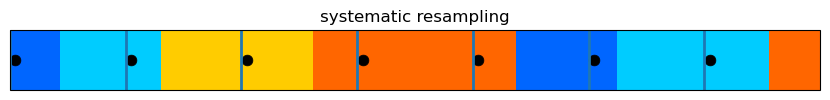

In [30]:
from kf_book.pf_internal import plot_systematic_resample
plot_systematic_resample([.1, .2, .3, .4, .2, .3, .1])

Having seen the earlier examples the code couldn't be simpler.

In [31]:
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions 
    # with a consistent random offset
    positions = (np.arange(N) + random()) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

   
Import from FilterPy with

```python
from filterpy.monte_carlo import systematic_resample
 ```

### Choosing a Resampling Algorithm

Let's look at the four algorithms at once so they are easier to compare.

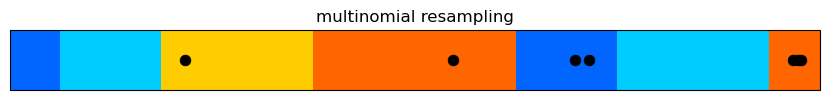

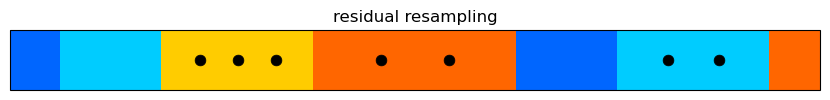

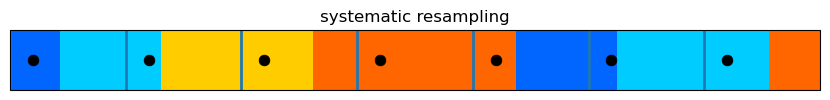

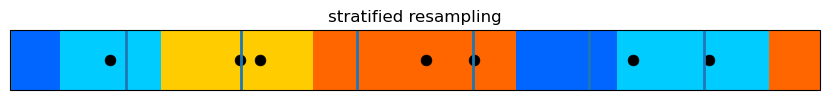

In [32]:
a = [.1, .2, .3, .4, .2, .3, .1]
np.random.seed(4)
plot_multinomial_resample(a)
plot_residual_resample(a)
plot_systematic_resample(a)
plot_stratified_resample(a)

The performance of the multinomial resampling is quite bad. There is a very large weight that was not sampled at all. The largest weight only got one resample, yet the smallest weight was sample was sampled twice. Most tutorials on the net that I have read use multinomial resampling, and I am not sure why. Multinomial resampling is rarely used in the literature or for real problems. I recommend not using it unless you have a very good reason to do so.

The residual resampling algorithm does excellently at what it tries to do: ensure all the largest weights are resampled multiple times. It doesn't evenly distribute the samples across the particles - many reasonably large weights are not resampled at all. 

Both systematic and stratified perform very well. Systematic sampling does an excellent job of ensuring we sample from all parts of the particle space while ensuring larger weights are proportionality resampled more often. Stratified resampling is not quite as uniform as systematic resampling, but it is a bit better at ensuring the higher weights get resampled more.

Plenty has been written on the theoretical performance of these algorithms, and feel free to read it.  In practice I apply particle filters to problems that resist analytic efforts, and so I am a bit dubious about the validity of a specific analysis to these problems. In practice both the stratified and systematic algorithms perform well and similarly across a variety of problems. I say try one, and if it works stick with it. If performance of the filter is critical try both, and perhaps see if there is literature published on your specific problem that will give you better guidance. 

## Summary

This chapter only touches the surface of what is a vast topic. My goal was not to teach you the field, but to expose you to practical Bayesian Monte Carlo techniques for filtering. 

Particle filters are a type of *ensemble* filtering. Kalman filters represents state with a Gaussian. Measurements are applied to the Gaussian using Bayes Theorem, and the prediction is done using state-space methods. These techniques are applied to the Gaussian - the probability distribution.

In contrast, ensemble techniques represent a probability distribution using a discrete collection of points and associated probabilities. Measurements are applied to these points, not the Gaussian distribution. Likewise, the system model is applied to the points, not a Gaussian. We then compute the statistical properties of the resulting ensemble of points.

These choices have many trade-offs. The Kalman filter is very efficient, and is an optimal estimator if the assumptions of linearity and Gaussian noise are true. If the problem is nonlinear than we must linearize the problem. If the problem is multimodal (more than one object being tracked) then the Kalman filter cannot represent it. The Kalman filter requires that you know the state model. If you do not know how your system behaves the performance is poor.

In contrast, particle filters work with any arbitrary, non-analytic probability distribution. The ensemble of particles, if large enough, form an accurate approximation of the distribution. It performs wonderfully even in the presence of severe nonlinearities. Importance sampling allows us to compute probabilities even if we do not know the underlying probability distribution. Monte Carlo techniques replace the analytic integrals required by the other filters. 

This power comes with a cost. The most obvious costs are the high computational and memory burdens the filter places on the computer. Less obvious is the fact that they are fickle. You have to be careful to avoid particle degeneracy and divergence. It can be very difficult to prove the correctness of your filter. If you are working with multimodal distributions you have further work to cluster the particles to determine the paths of the multiple objects. This can be very difficult when the objects are close to each other.

There are many different classes of particle filter; I only described the naive SIS algorithm, and followed that with a SIR algorithm that performs well. There are many classes of filters, and many examples of filters in each class. It would take a small book to describe them all. 

When you read the literature on particle filters you will find that it is strewn with integrals. We perform computations on probability distributions using integrals, so using integrals gives the authors a powerful and compact notation. You must recognize that when you reduce these equations to code you will be representing the distributions with particles, and integrations are replaced with sums over the particles. If you keep in mind the core ideas in this chapter the material shouldn't be daunting. 

## References

[1] *Importance Sampling*, Wikipedia.
https://en.wikipedia.org/wiki/Importance_sampling
